In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim

from pathlib import Path
from torch.utils.data import DataLoader

from torchfitter.trainer import Trainer
from torchfitter.utils import DataWrapper
from torchfitter.regularization import L1Regularization

from sklearn.model_selection import train_test_split

torch.manual_seed(0)
np.random.seed(0)

In [3]:
DATA_PATH = Path(os.path.abspath('')).parent / "tests/data"

In [4]:
X = np.load(DATA_PATH / "features.npy")
y = np.load(DATA_PATH / "labels.npy")

y = y.reshape(-1,1)

In [5]:
# simplest case of cross-validation
X_train, X_val, y_train, y_val = train_test_split(
    X, 
    y, 
    test_size=0.33, 
    random_state=42
)

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [7]:
model = nn.Linear(in_features=1, out_features=1)
model.to(device)

regularizer = L1Regularization(regularization_rate=0.01, biases=False)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

In [8]:
from torchfitter.callbacks import Logger

In [9]:
logger = LoggerCallback(update_step=50)

In [10]:
trainer = Trainer(
    model=model, 
    criterion=criterion,
    optimizer=optimizer, 
    regularizer=regularizer,
    device=device,
    callbacks=[logger]
)

In [11]:
# wrap data in Dataset
train_wrapper = DataWrapper(
    X_train, 
    y_train, 
    dtype_X='float', 
    dtype_y='float'
)
val_wrapper = DataWrapper(X_val, y_val, dtype_X='float', dtype_y='float')

# torch Loaders
train_loader = DataLoader(train_wrapper, batch_size=32)
val_loader = DataLoader(val_wrapper, batch_size=32)

In [12]:
# fitting process
trainer.fit(train_loader, val_loader, epochs=500)

INFO:root:Epoch 0/500 | Train loss: 8433.490234375 | Validation loss: 8433.490234375 | Time/epoch: 0.02397 seconds
INFO:root:Epoch 1/500 | Train loss: 8429.580078125 | Validation loss: 8429.580078125 | Time/epoch: 0.02094 seconds
INFO:root:Epoch 50/500 | Train loss: 8241.99609375 | Validation loss: 8241.99609375 | Time/epoch: 0.01519 seconds
INFO:root:Epoch 100/500 | Train loss: 8054.20068359375 | Validation loss: 8054.20068359375 | Time/epoch: 0.0157 seconds
INFO:root:Epoch 150/500 | Train loss: 7869.5625 | Validation loss: 7869.5625 | Time/epoch: 0.01618 seconds
INFO:root:Epoch 200/500 | Train loss: 7687.80126953125 | Validation loss: 7687.80126953125 | Time/epoch: 0.01512 seconds
INFO:root:Epoch 250/500 | Train loss: 7508.73291015625 | Validation loss: 7508.73291015625 | Time/epoch: 0.01521 seconds
INFO:root:Epoch 300/500 | Train loss: 7332.2333984375 | Validation loss: 7332.2333984375 | Time/epoch: 0.01549 seconds
INFO:root:Epoch 350/500 | Train loss: 7158.2275390625 | Validation l

In [13]:
from torchfitter.conventions import ParamsDict

In [14]:
# predictions
with torch.no_grad():
    y_pred = model(torch.from_numpy(X_val).float().to(device)).cpu().numpy()

In [15]:
import matplotlib.pyplot as plt

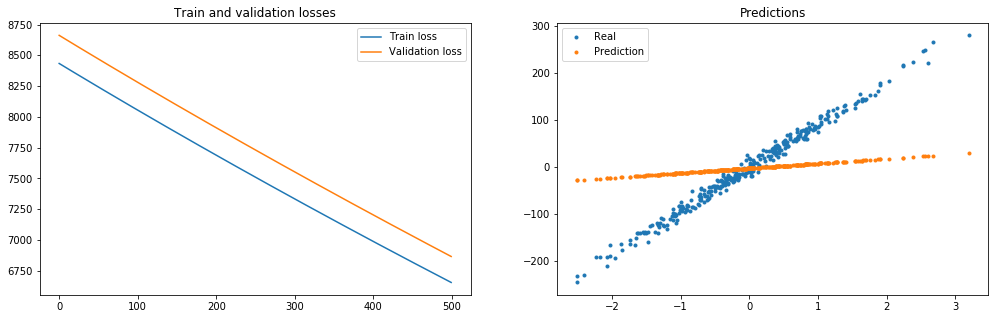

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(17,5))

ax[0].plot(trainer.params_dict['history']['train_loss'], label='Train loss')
ax[0].plot(trainer.params_dict['history']['validation_loss'], label='Validation loss')
ax[0].set_title('Train and validation losses')
ax[0].legend();

ax[1].plot(X_val, y_val, '.', label="Real")
ax[1].plot(X_val, y_pred, '.', label="Prediction")
ax[1].set_title('Predictions')
ax[1].legend();